In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path='/content/drive/MyDrive/SARS-COV-2_Ct-Scan_Dataset/'

In [4]:
import pathlib
data = pathlib.Path(path) 
count = len(list(data.glob('*/*.png')))
count

2480

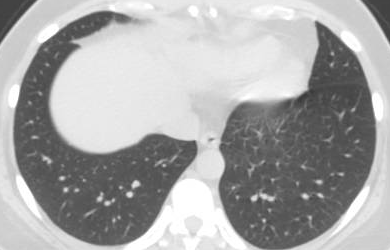

In [5]:
import PIL
images=list(data.glob('*/*.png'))
PIL.Image.open(images[0])

In [6]:
img = PIL.Image.open(images[0])
img.size

(390, 250)

In [7]:
types=['COVID', 'non-COVID']

dir=path

train_data = []

for index, val in enumerate(types):
    for file in os.listdir(os.path.join(dir, val)):
        train_data.append([val + "/" + file, index, val])
        
df = pd.DataFrame(train_data, columns = ['file', 'label','class'])

df.head()

,file,label,class
0,COVID/Covid (1203).png,0,COVID
1,COVID/Covid (1245).png,0,COVID
2,COVID/Covid (1244).png,0,COVID
3,COVID/Covid (1216).png,0,COVID
4,COVID/Covid (127).png,0,COVID


In [8]:
temp = df['file']

In [9]:
temp = temp[2480:2468:-4]

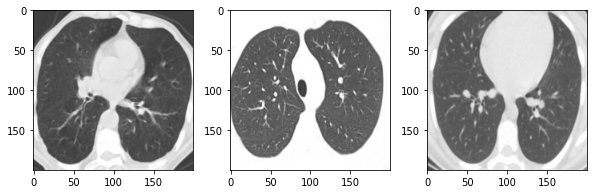

In [10]:
plt.figure(figsize=(10,10))

for index, file in enumerate(temp.values):
    image = cv2.imread(os.path.join(dir,file))
    if image is not None:
        plt.subplot(3,3,index+1)    
        plt.imshow(cv2.resize(image,(200,200),interpolation = cv2.INTER_AREA).astype('uint8'))

In [11]:
df = df.sample(frac = 1, replace=False, random_state = 42)

In [12]:
df = df.reset_index(drop = True)

In [13]:
new_df = np.zeros((df.shape[0], 200, 200, 3))

In [14]:
for index, file in enumerate(df['file'].values):
    image = cv2.imread(os.path.join(dir,file))
    if image is not None:
        new_df[index] = cv2.resize(image,(200,200),interpolation = cv2.INTER_AREA)

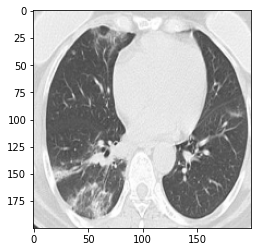

In [15]:
plt.imshow(new_df[0].astype('uint8'))

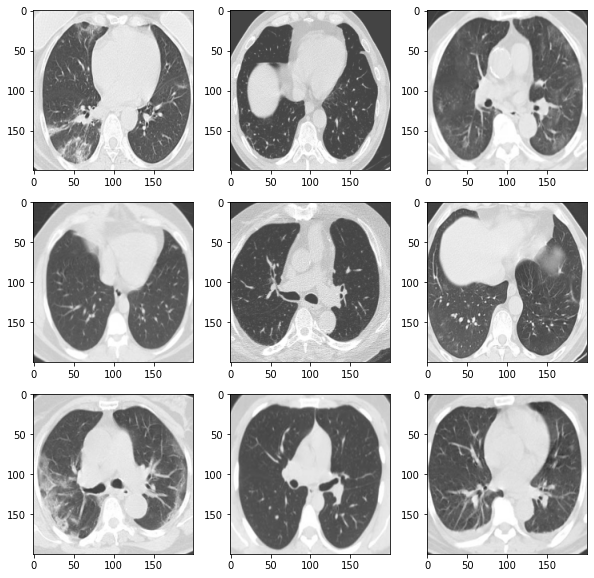

In [16]:
plt.figure(figsize=(10,10)) 

for i in range(9):
    plt.subplot(3,3,i+1)    
    plt.imshow(new_df[i].astype('uint8'))

plt.show()

In [17]:
labels=df['label'].values

In [18]:
type(new_df[0])

numpy.ndarray

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(new_df,
                                                  labels,
                                                  test_size = 0.2,
                                                  random_state = 42)

In [21]:
X_train =  tf.convert_to_tensor(X_train)
X_test =  tf.convert_to_tensor(X_test)
Y_train =  tf.convert_to_tensor(Y_train)
Y_test =  tf.convert_to_tensor(Y_test)

In [22]:
print(f'X_train:',X_train.shape)
print(f'X_val:',X_test.shape)
print(f'Y_train:',Y_train.shape)
print(f'Y_val:',Y_test.shape)

X_train: (1984, 200, 200, 3)
X_val: (496, 200, 200, 3)
Y_train: (1984,)
Y_val: (496,)


In [23]:
base_model=tf.keras.applications.MobileNetV2(weights='imagenet',include_top=False, input_shape=(200, 200, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [24]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 100, 100, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 100, 100, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [25]:
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from tensorflow.keras.optimizers import Adam

In [26]:
base_model.trainable = False

In [27]:
last_layer = base_model.get_layer('out_relu')
print(last_layer.output_shape)

(None, 7, 7, 1280)


In [28]:
x = Flatten()(last_layer.output)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = 'sigmoid')(x)
model = Model(base_model.input, x)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 100, 100, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 100, 100, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [30]:
optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),])

In [31]:
from keras.preprocessing.image import ImageDataGenerator

In [32]:
datagen = ImageDataGenerator(vertical_flip = True) 

In [33]:
datagen.fit(X_train)

In [34]:
X_train.shape[0]

1984

In [35]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

In [36]:
print(X_train.dtype)
print(Y_train.dtype)
print(X_test.dtype)
print(Y_test.dtype)

<dtype: 'float64'>
<dtype: 'int64'>
<dtype: 'float64'>
<dtype: 'int64'>


In [37]:
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=64),
               steps_per_epoch=X_train.shape[0]//64 ,
               epochs=32,
               verbose=1,
               callbacks=[reducer, checkpoint],
               validation_data=(X_test, Y_test))

Epoch 1/32
31/31 [==============================] - ETA: 0s - loss: 9.5810 - accuracy: 0.6557 - precision: 0.6643 - recall: 0.6584
Epoch 1: val_loss improved from inf to 1.36093, saving model to model.h5
31/31 [==============================] - 126s 4s/step - loss: 9.5810 - accuracy: 0.6557 - precision: 0.6643 - recall: 0.6584 - val_loss: 1.3609 - val_accuracy: 0.8206 - val_precision: 0.7490 - val_recall: 0.8843 - lr: 0.0010
Epoch 2/32
31/31 [==============================] - ETA: 0s - loss: 0.8719 - accuracy: 0.7984 - precision: 0.8032 - recall: 0.8016
Epoch 2: val_loss improved from 1.36093 to 0.32605, saving model to model.h5
31/31 [==============================] - 112s 4s/step - loss: 0.8719 - accuracy: 0.7984 - precision: 0.8032 - recall: 0.8016 - val_loss: 0.3261 - val_accuracy: 0.8690 - val_precision: 0.8159 - val_recall: 0.9028 - lr: 0.0010
Epoch 3/32
31/31 [==============================] - ETA: 0s - loss: 0.3548 - accuracy: 0.8412 - precision: 0.8395 - recall: 0.8519
Epoch 3

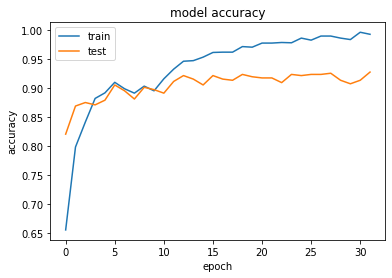

In [38]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

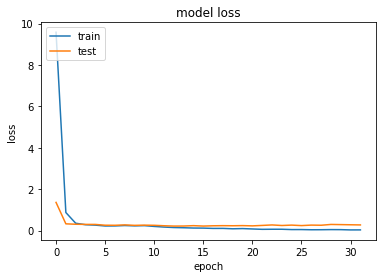

In [39]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
x=X_test[5]

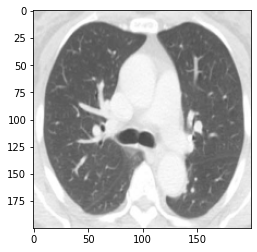

In [41]:
plt.imshow((x.numpy()).astype('uint8'))

In [42]:
x=tf.reshape(x,(1,200,200,3))

In [43]:
print(np.round(model.predict(x)))

1/1 [==============================] - 1s 1s/step
[[1.]]


In [44]:
print(Y_test[5])

tf.Tensor(1, shape=(), dtype=int64)


In [45]:
x=X_test[340]

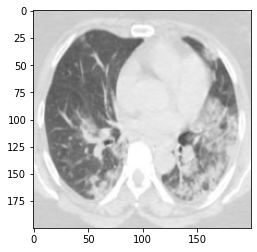

In [46]:
plt.imshow((x.numpy()).astype('uint8'))

In [47]:
x=tf.reshape(x,(1,200,200,3))

In [48]:
print(np.round(model.predict(x)))

1/1 [==============================] - 0s 81ms/step
[[0.]]


In [49]:
print(Y_test[340])

tf.Tensor(0, shape=(), dtype=int64)
